# Predicting Used Car Prices with Linear Regression

This project explores the use of Linear Regression to predict the prices of second-hand cars based on key features such as mileage, year, and engine volume. 

The dataset represents listings from an online platform where individual sellers post their car details. Each row corresponds to a unique vehicle being offered for resale.

We'll walk through a full machine learning workflow:
- Preprocessing the data
- Selecting relevant features and target variables
- Checking assumptions for linear regression and handling violations
- Scaling the data
- Splitting into training and test sets
- Building and evaluating a linear regression model

The final model will help estimate car prices based on input specifications and provide insights into what features drive value.

## Step 1: Importing Required Libraries

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [5]:
sns.set()

# Define custom color palettes
cool_tones = ['#347C8D', '#5B7F9A', '#7887AB', '#5D6D7E']
warm_tones = ['#B35C4A', '#CB6843', '#E18257', '#D1604D', '#CB6843', '#E3A370', '#A0432F']

# Set color palette
sns.set_palette(cool_tones)

# Set the style and format the spine
sns.set_style("white", {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": True, "axes.spines.bottom": True})
plt.rcParams['axes.edgecolor'] = '#444444'

## Step 2: Loading the Raw Dataset

In [7]:
raw_data = pd.read_csv('../data/second_hand_car_data.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


## Step 3: Data Preprocessing

### Exploring Descriptive Statistics

In [10]:
# Print column info 
print(raw_data.info())

# Generate desciptive statistics for all fields
raw_data.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB
None


,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


**Initial Observations**

- There are **4,345** total rows in the dataset, but some columns like `Price` and `EngineV` have missing values.
- The `Model` column contains **312 unique values**, which would require creating an equal number of dummy variables — too many for a linear model.
- Fortunately, the `Model` information largely overlaps with other features like `Brand`, `Year`, and `EngineV`, so we can safely drop it.
- The `Registration` column is overwhelmingly filled with **"Yes"** values (3,947 of 4,345), so it doesn't offer any useful variability for modeling.

### Selecting Variables of Interest

As discussed, we’ll begin by dropping the `Model` and `Registration` columns since they don’t add useful information for price prediction.

In [14]:
# Drop the column 'Model' and 'Registration'
data = raw_data.drop(columns = ['Model', 'Registration'], axis = 1)
data.columns

Index(['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type', 'Year'], dtype='object')

When it comes to second-hand cars, price is heavily influenced by a few key specifications:

- **Brand**: Luxury and premium brands tend to have higher resale values.
- **Mileage**: Higher mileage usually lowers the value, signaling more wear and tear.
- **Engine Volume (EngineV)**: Sports and performance vehicles typically have larger engines.
- **Year**: Newer cars generally cost more — with some exceptions like vintage collectibles.

Other categorical features will be reviewed individually and encoded appropriately if useful.

### Handling Missing Values
Earlier, we observed that the dataset contains missing values in the `Price` and `EngineV` columns. These features are crucial to our analysis — `Price` is our target variable, and `EngineV` is one of the key predictors.

Let's take a closer look at the number of missing values in each column.

In [17]:
# View the number of missing values in each column
data.isnull().sum()

Brand            0
Price          172
Body             0
Mileage          0
EngineV        150
Engine Type      0
Year             0
dtype: int64

Given that missing values occur only in a small fraction of the dataset (less than **1%** of observations), and that these values belong to essential features, we will drop those rows. This approach allows us to maintain data quality without sacrificing too much information.

In [19]:
# Drop rows with missing values
data_no_null = data.dropna(axis = 0)
data_no_null.shape

(4025, 7)

### Exploring the Distributions of Key Features

Before we begin modeling, it’s important to understand how our main variables are distributed. This helps us spot potential skewness, outliers, and non-linear relationships — all of which influence how we prepare our data and choose modeling techniques.

We'll visualize the probability density functions **(PDFs)** of four key numerical features: `Price`, `Mileage`, `EngineV`, and `Year`.

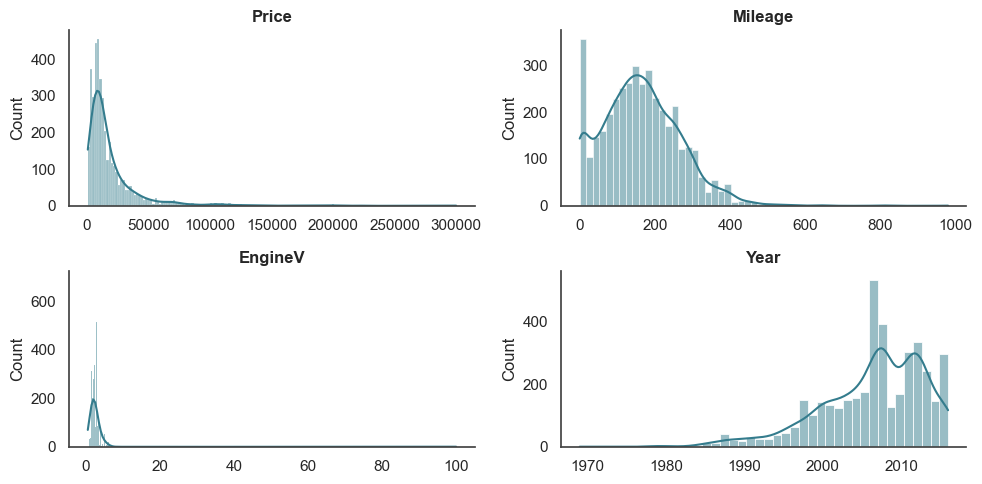

In [21]:
# Plot the PDFs of key continuous variables
fig, axes = plt.subplots(2, 2, figsize = (10, 5))
columns_pdf = ['Price', 'Mileage', 'EngineV', 'Year']
title_format = {'fontweight': 'bold', 'fontsize': 12}
title_format_large = {'fontweight': 'bold', 'fontsize': 14}

for idx, col in enumerate(columns_pdf):
    i = idx // 2  # row index
    j = idx % 2   # column index
    sns.histplot(data_no_null[col], kde = True, ax = axes[i, j], color = cool_tones[0])
    axes[i, j].set_title(col, fontdict = title_format)
    axes[i, j].set_xlabel('')

plt.tight_layout()
plt.show()

This visualization gives us a sense of the underlying shape of each variable:

- Are there outliers skewing the distribution?
- Is the data normally distributed or skewed?
- Should we consider transformations (like log-scaling) to normalize variables such as Price?

### Dealing with Outliers
Outliers are data points that significantly deviate from the rest of the dataset. These can distort statistical analyses and models — especially linear regression, which is sensitive to extreme values.

Let’s address outliers in four key features: `Price`, `Mileage`, `EngineV`, and `Year`.

**1. Price**

In [25]:
data_no_null['Price'].describe()

count      4025.000000
mean      19552.308065
std       25815.734988
min         600.000000
25%        6999.000000
50%       11500.000000
75%       21900.000000
max      300000.000000
Name: Price, dtype: float64


**Observation:**

- Mean price is around $19,552.

- 75% of cars are priced under $21,900.

- However, the maximum price is $300,000 — far higher than the rest. This highly **right-skewed** distribution suggests the presence of extreme values.

We’ll remove the **top 1%** of values using the 99th percentile as a threshold.

In [27]:
price_cap = data_no_null['Price'].quantile(0.99)
data_no_outliers = data_no_null[data_no_null['Price'] < price_cap]

**2. Mileage**

Mileage also tends to be **right-skewed**, where a few high-mileage vehicles may not represent the typical range.

In [29]:
mileage_cap = data_no_outliers['Mileage'].quantile(0.99)
data_no_outliers = data_no_outliers[data_no_outliers['Mileage'] < mileage_cap]

**3. Engine Volume (EngineV)**

In [31]:
data_no_null['EngineV'].describe()

count    4025.000000
mean        2.764586
std         4.935941
min         0.600000
25%         1.800000
50%         2.200000
75%         3.000000
max        99.990000
Name: EngineV, dtype: float64

**Observation:**

- Most engine volumes fall between 1.8L and 3.0L.

- A max value of **99.99L** is clearly unrealistic and likely an entry error.

We'll cap the acceptable range at **6.5L**, which is a reasonable upper limit for modern consumer vehicles.

In [33]:
data_no_outliers = data_no_outliers[data_no_outliers['EngineV'] <= 6.5]

**4. Year**
Most cars in the dataset are relatively new, but a few very old models may skew our analysis.

We’ll remove the **bottom 10%** by taking the 10th percentile:

In [35]:
year_floor = data_no_outliers['Year'].quantile(0.10)
data_no_outliers = data_no_outliers[data_no_outliers['Year'] > year_floor]

### Finalizing the Cleaned Dataset

After handling outliers, we reset the index and summarize the cleaned dataset:

In [37]:
data_cleaned = data_no_outliers.reset_index(drop = True)
data_cleaned.describe(include = 'all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
count,3460,3460.000000,3460,3460.000000,3460.000000,3460,3460.000000
unique,7,NaN,6,NaN,NaN,4,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,NaN
freq,762,NaN,1208,NaN,NaN,1698,NaN
mean,NaN,19802.694757,NaN,147.936127,2.465220,NaN,2008.148555
std,NaN,19541.538728,NaN,86.679171,0.974286,NaN,4.574514
min,NaN,1200.000000,NaN,0.000000,0.600000,NaN,1999.000000
25%,NaN,8400.000000,NaN,85.000000,1.800000,NaN,2005.000000
50%,NaN,12850.000000,NaN,148.000000,2.200000,NaN,2008.000000
75%,NaN,23500.000000,NaN,205.000000,3.000000,NaN,2012.000000


**Summary:**

We've now removed approximately **250 outlier observations**, improving the quality of our dataset and making it more suitable for linear regression. All feature ranges now fall within realistic, interpretable bounds.

We'll compare how the distributions of key numerical features have changed after removing outliers.

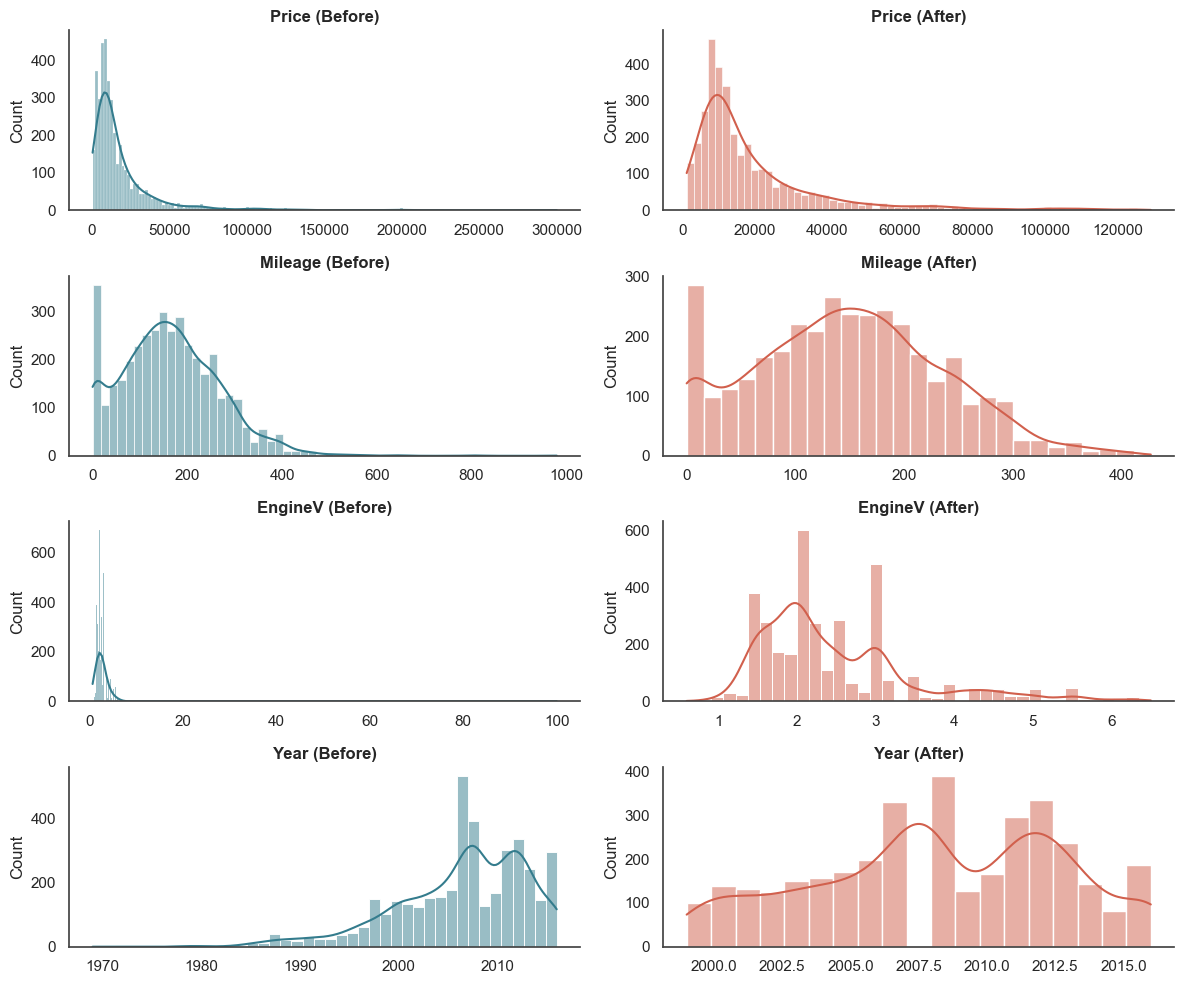

In [39]:
# Features to compare
features = ['Price', 'Mileage', 'EngineV', 'Year']

# Set up the subplot grid
fig, axes = plt.subplots(len(features), 2, figsize = (12, 10))

for i, feature in enumerate(features):
    # Before outlier removal
    sns.histplot(data_no_null[feature], kde = True, ax = axes[i, 0])
    axes[i, 0].set_title(f'{feature} (Before)', fontdict = title_format)
    axes[i, 0].set_xlabel('')

    # After outlier removal
    sns.histplot(data_cleaned[feature], kde = True, ax = axes[i, 1], color = warm_tones[3])
    axes[i, 1].set_title(f'{feature} (After)', fontdict = title_format)
    axes[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()

## Step: 4 Checking the OLS assumptions

Before we jump into modeling, it's important to assess whether our data meets the key assumptions of **Ordinary Least Squares (OLS)** regression. We’ve already cleaned and preprocessed our data — next, we'll check for **linearity**, a foundational assumption for linear regression.

We're especially interested in the relationships between `Price` and the continuous numerical variables: `Year`, `EngineV`, and `Mileage`. Categorical variables like `Brand`, `Body`, and `Engine Type` will be handled separately using dummy variables.

### Visualizing Linearity
Let’s use scatter plots to examine the relationship between the **target** (Price) and these potential **predictors**:

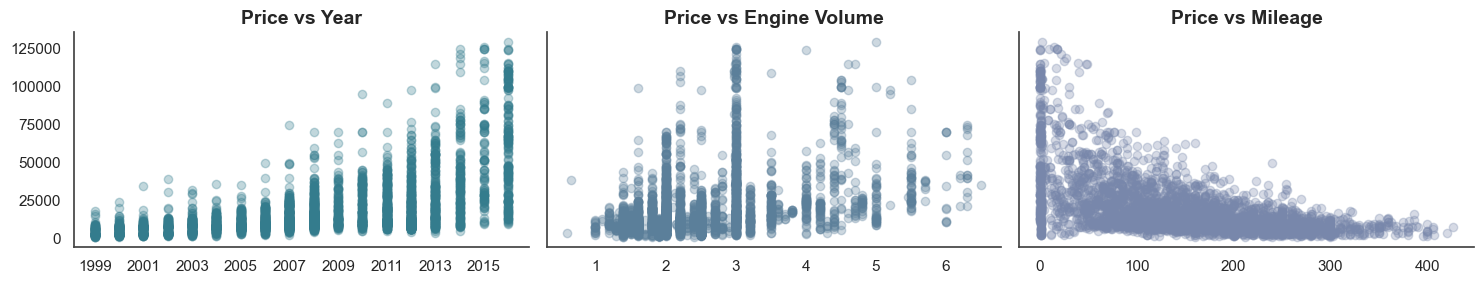

In [42]:
# Scatter plots to examine linearity
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 3))

year_range = np.arange(data_cleaned['Year'].min(), data_cleaned['Year'].max(), 2)
ax1.scatter(data_cleaned['Year'], data_cleaned['Price'], alpha = 0.3, color = cool_tones[0])
ax1.set_title('Price vs Year', fontdict = title_format_large)
ax1.set_xticks(year_range)

ax2.scatter(data_cleaned['EngineV'], data_cleaned['Price'], alpha = 0.3, color = cool_tones[1])
ax2.set_title('Price vs Engine Volume', fontdict = title_format_large)

ax3.scatter(data_cleaned['Mileage'], data_cleaned['Price'], alpha = 0.3, color = cool_tones[2])
ax3.set_title('Price vs Mileage', fontdict = title_format_large)

plt.tight_layout()
plt.show()

**Observations:**

There are visible relationships, but they aren’t strictly linear.

In particular, `Price` appears to be **right-skewed**, suggesting an exponential distribution.


This violates the linearity assumption. Fortunately, there’s a simple fix: **log-transforming** the dependent variable.

### Relaxing Linearity with a Log Transformation
Taking the log of `Price` can help us linearize the relationships and stabilize variance (addressing **heteroskedasticity** as well).

In [45]:
# Log-transform the Price
data_cleaned['Log Price'] = np.log(data_cleaned['Price'])

Now, let’s visualize the relationships again — this time using Log Price instead of Price:

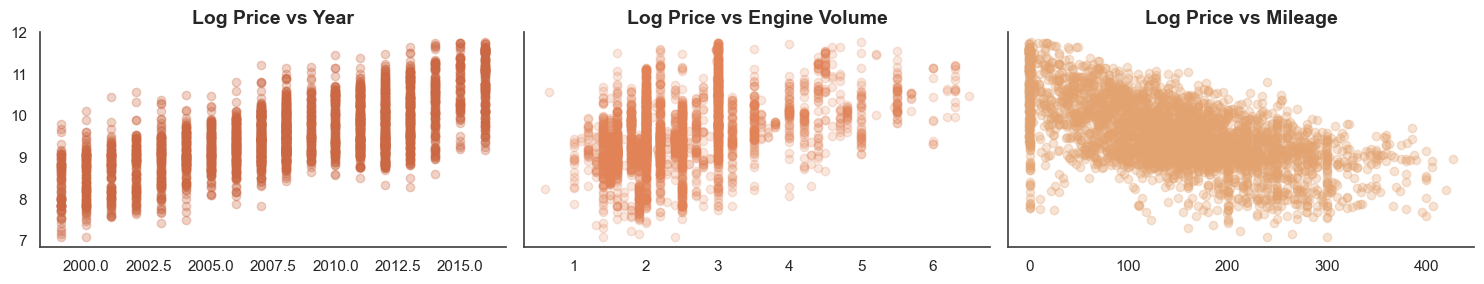

In [47]:
# Scatter plots after log transformation
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 3))

ax1.scatter(data_cleaned['Year'], data_cleaned['Log Price'], alpha = 0.3, color = warm_tones[4])
ax1.set_title('Log Price vs Year', fontdict = title_format_large)

ax2.scatter(data_cleaned['EngineV'], data_cleaned['Log Price'], alpha = 0.2, color = warm_tones[2])
ax2.set_title('Log Price vs Engine Volume', fontdict = title_format_large)

ax3.scatter(data_cleaned['Mileage'], data_cleaned['Log Price'], alpha = 0.3, color = warm_tones[5])
ax3.set_title('Log Price vs Mileage', fontdict = title_format_large)

plt.tight_layout()
plt.show()

The results are much better! The relationships now appear more linear and suitable for regression.

Since we’ll be using Log Price as the new target variable, let’s remove the original Price column:

In [49]:
# Drop the original Price column
data_cleaned.drop(columns=['Price'], inplace=True)
data_cleaned.head()


,Brand,Body,Mileage,EngineV,Engine Type,Year,Log Price
0,Mercedes-Benz,van,427,2.9,Diesel,1999,8.974618
1,Mercedes-Benz,sedan,358,5.0,Gas,2003,9.495519
2,Audi,crossover,240,4.2,Petrol,2007,10.043249
3,Toyota,crossover,120,2.0,Petrol,2011,9.814656
4,Audi,vagon,200,2.7,Diesel,2006,9.560997


**Summary of OLS Assumptions:**

| **Assumption**                | **Explanation**                                                                 | **Action Taken** / **Observation**                                                                 |
|------------------------------|----------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| 1. Linearity            | Relationship between predictors and target must be linear.                      | Plotted scatter plots. Observed non-linear patterns. Applied **log transformation** to `Price`.     |
| 2. Normality of Errors   | Residuals should be normally distributed.                                       | Applied **log transformation** to improve normality. Supported further by **Central Limit Theorem**.|
| 3. Homoscedasticity      | Constant variance of errors across predictors.                                  | Log transformation also helps mitigate **heteroskedasticity** (non-constant variance).              |
| 4. No Autocorrelation    | Errors should not be correlated across observations.                            | Not a concern — data is cross-sectional, not time-based.                                            |
| 5. No Multicollinearity  | Predictors should not be highly correlated.                                     | Will be checked during feature selection (e.g., using **VIF**).                                     |

---

### Multicollinearity
Multicollinearity occurs when two or more predictor variables are highly correlated with each other. This can distort the estimation of coefficients in a regression model and reduce interpretability.

In our case, it's logical to suspect that `Year` and `Mileage` might be correlated — newer cars typically have lower mileage. To detect and quantify multicollinearity, we use **Variance Inflation Factor (VIF)** from the `statsmodels` library.

- *VIF = 1 - No correlation.*
- *VIF between 1 and 5 - Acceptable.*
- *VIF > 5 - Potential multicollinearity concern.*
- *VIF > 10 - Serious multicollinearity.*

Full documentation: [statsmodels.org - VIF](https://www.statsmodels.org/dev/_modules/statsmodels/stats/outliers_influence.html#variance_inflation_factor)

In [52]:
# View all columns in the cleaned dataset
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type', 'Year',
       'Log Price'], dtype=object)

In [53]:
# Import the VIF function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a subset of continuous variables to check for multicollinearity
variables = data_cleaned[['Mileage', 'Year', 'EngineV']]

# Create a DataFrame to store VIF values
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif.index = variables.columns

# Display the VIF table
vif

,VIF
Mileage,3.892790
Year,10.110043
EngineV,7.400148


**Interpretation & Action:**

If we look at the VIF table, we'll likely observe that the `Year` variable has a high VIF, confirming our hypothesis. Since multicollinearity can distort our regression estimates, we choose to **remove** `Year` from our dataset.

In [55]:
# Drop 'Year' to reduce multicollinearity
data_no_multicollinearity = data_cleaned.drop(['Year'], axis = 1)

# Check the remaining features
data_no_multicollinearity.columns

Index(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type', 'Log Price'], dtype='object')

### Create Dummy Variables
To handle categorical variables for regression, we convert them into dummy variables using `pandas.get_dummies()`. This function creates new binary columns (0 or 1) for each category in a feature.

*Note: If a categorical variable has **N categories**, we only need **N - 1 dummy variables**. One category is omitted and acts as the reference level (baseline), avoiding multicollinearity. For example, if we drop `Brand_Audi`, it becomes the benchmark, and all other brand dummies values are in comparision to this baseline value.*

In [57]:
# Create dummy variables, dropping the first to avoid multicollinearity
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first = True)

# Check current column names
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'Log Price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol'], dtype=object)

For consistency and interpretability, we’ll rearrange the columns, putting the dependent variable Log Price first, followed by numerical and dummy variables.

In [59]:
# Rearranged column order
cols = ['Log Price', 'Mileage', 'EngineV', 'Brand_BMW',
        'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
        'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
        'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
        'Engine Type_Other', 'Engine Type_Petrol']

# Create a new dataframe with reordered columns
data_preprocessed = data_with_dummies[cols]

# Preview the final preprocessed data
data_preprocessed.head()

,Log Price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,8.974618,427,2.9,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,9.495519,358,5.0,False,True,False,False,False,False,False,False,True,False,False,True,False,False
2,10.043249,240,4.2,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,9.814656,120,2.0,False,False,False,False,True,False,False,False,False,False,False,False,False,True
4,9.560997,200,2.7,False,False,False,False,False,False,False,False,False,True,False,False,False,False


With this, we are done with the preprocessing step. Next, we're ready for building the **Linear Regression model**.

## Step 5: Linear Regression Model

### Declare Inputs and Targets
We’ll now define our **dependent variable** (`Log Price`) and **independent variables** (all other features):

In [63]:
# Define the target (dependent variable)
targets = data_preprocessed['Log Price']

# Define the input features by dropping the target column
inputs = data_preprocessed.drop(columns = ['Log Price'], axis = 1)

### Scale the data

We standardize the **input features** to ensure they’re on the same scale. This prevents features with larger values from disproportionately influencing the model.

*Note: While scaling dummy variables isn’t recommended in classical stats models (since 0/1 represents categories), in machine learning, it doesn’t affect predictive power. However, they do lose their interpretive "dummy" nature when scaled.*

In [65]:
# Import the scaler
from sklearn.preprocessing import StandardScaler

# Create and fit the scaler on the input features
scaler = StandardScaler()
scaler.fit(inputs)

# Transform the inputs using the fitted scaler
inputs_scaled = scaler.transform(inputs)

# View the scaled inputs
inputs_scaled

array([[ 3.2199686 ,  0.44631964, -0.41722336, ..., -0.39108697,
        -0.16342041, -0.73473185],
       [ 2.42381455,  2.6020547 , -0.41722336, ...,  2.55697602,
        -0.16342041, -0.73473185],
       [ 1.06227573,  1.7808223 , -0.41722336, ..., -0.39108697,
        -0.16342041,  1.36104077],
       ...,
       [-1.60310958,  0.54897369, -0.41722336, ..., -0.39108697,
        -0.16342041, -0.73473185],
       [-1.69541729,  1.06224394,  2.39679773, ..., -0.39108697,
        -0.16342041,  1.36104077],
       [-0.27618615, -0.47756682, -0.41722336, ..., -0.39108697,
        -0.16342041, -0.73473185]])

Our features are now standardized and ready for model training.

### Split into Training and Testing Dataset

Now that our features are standardized, it's time to split the data into **training** and **testing** sets. This helps us prevent **overfitting** and evaluate how well the model performs on unseen data. We’ll use an **80-20 split**, where:

- 80% of the data is used to train the model.
- 20% is held back for testing.
- We set a random_state to ensure reproducibility.

In [68]:
# Import the module for splitting the data
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state = 300)

### Train Linear Regression Model

**1. Fit the Regression Model:**

We’ll start by training a log-linear regression model using the scaled training data.

In [71]:
# Initialize the model
reg = LinearRegression()

# Fit the model to the training data
reg.fit(x_train, y_train)

LinearRegression()

**2. Predictions vs Actuals:**

Let’s compare the model’s predictions to the actual target values using a scatter plot. We will also analyze the **residuals** (the difference between the actual and predicted values) to check the assumptions of linear regression.

In [73]:
# Predict using the training data
y_hat = reg.predict(x_train)

# Calculate residuals
residual = y_train - y_hat

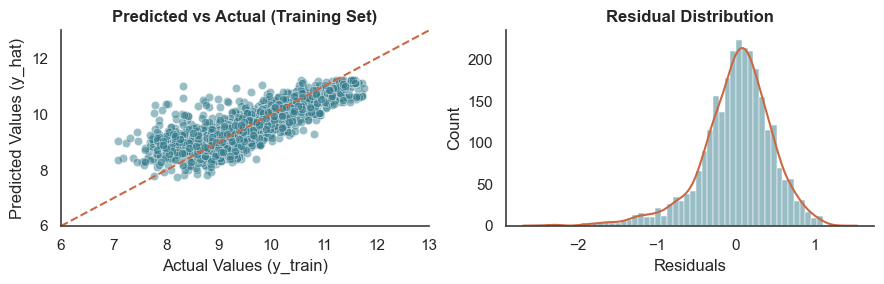

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))

# Visualize a scatterplot between predicted vs actual values
sns.scatterplot(x = y_train, y = y_hat, alpha = 0.5, ax = ax1, color = cool_tones[0])
ax1.set_xlabel('Actual Values (y_train)')
ax1.set_ylabel('Predicted Values (y_hat)')
ax1.set_title('Predicted vs Actual (Training Set)', fontdict = title_format)
ax1.set_xlim(6, 13)
ax1.set_ylim(6, 13)
ax1.plot([6, 13], [6, 13], color = warm_tones[1], linestyle = '--')  # 45° reference line

# Residual distribution
sns.histplot(residual, kde = True, ax = ax2, color = cool_tones[0])
ax2.lines[0].set_color(warm_tones[1])
ax2.set_title('Residual Distribution', fontdict = title_format)
ax2.set_xlabel('Residuals')

fig.tight_layout()
plt.show()

**Interpretation:**

- If the model were perfect, all points would lie exactly on the red **45° line**. In our case, predictions generally cluster around the line, which suggests a reasonably good fit and definitely better than random guessing.

- **Residuals** appear roughly normally distributed with a mean near 0. **Slight left skew** suggests that the model sometimes **overestimates** the target values more than it underestimates.

**4. R-squared Score:**

Let’s check how well our model explains the variance in the data:

In [77]:
reg.score(x_train, y_train)

0.6656653897871286

**Result:** ~0.67

This is a decent result — our model explains about **67% of the variability** in the target variable. While not perfect, it shows a solid foundation and can likely be improved in iterative versions through further feature engineering or model tuning.

### Find the Weights and Bias

In [80]:
# Intercept (bias)
reg.intercept_

9.55022230765649

In [81]:
# Summary table
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.495595
1,EngineV,0.218536
2,Brand_BMW,0.027469
3,Brand_Mercedes-Benz,0.040846
4,Brand_Mitsubishi,-0.120935
5,Brand_Renault,-0.154949
6,Brand_Toyota,-0.041328
7,Brand_Volkswagen,-0.049323
8,Body_hatch,-0.152247
9,Body_other,-0.082794


**1. Interpreting Numerical Variables:**

While the model isn’t directly interpretable (due to the log transformation of price and standardization of features), we can still make sense of the results:

- **Positive coefficients** mean that an increase in the feature is associated with a higher log price (and thus, a higher actual price). `EngineV` has a positive coefficient. Therefore, larger engine volumes tend to increase a car’s price.

- **Negative coefficients** indicate that an increase in the feature tends to lower the price. `Mileage` has a strong negative coefficient. Therefore, more mileage generally reduces the car’s value.

**2. Interpreting Dummies:**

`Brand`

- **Audi** was the dropped category, making it the **baseline.**

- Brands with **Positive weights** (BMW and Mercedes-Benz) are **more expensive** than Audi.

- **Negative weights** (the rest of the brands) are **cheaper** than Audi.

`Engine Type`

- **Diesel** is the **benchmark** here.

- All other engine types have **negative coefficients**, meaning they are **cheaper** than Diesel on average:

- **Petrol** has the strongest negative impact. It's the **cheapest** relative to Diesel.

We'll create two data Frames to store the weights for `Brand` and `Engine Type` for deriving the final insights.

In [85]:
# Create data frames to store weights for Brand and Engine Type
features = reg_summary.copy()
brands_bool = features['Features'].astype(str).str.startswith('Brand')
eng_bool = features['Features'].astype(str).str.startswith('Engine Type')

brands_df = features[brands_bool].copy()
engine_df = features[eng_bool].copy()

# Clean up 'Features' column to keep only the brand and engine type names
brands_df['Features'] = brands_df['Features'].astype(str).str.split('_').str[1]
engine_df['Features'] = engine_df['Features'].astype(str).str.split('_').str[1]

## Step 6: Model Testing and Evaluation

### Make Predictions on Test Data
Since our model is trained and fine-tuned, we can move to testing it on unseen data.

In [88]:
y_hat_test = reg.predict(x_test)

We visualize the relationship between the actual test targets and the predicted values using a scatter plot:

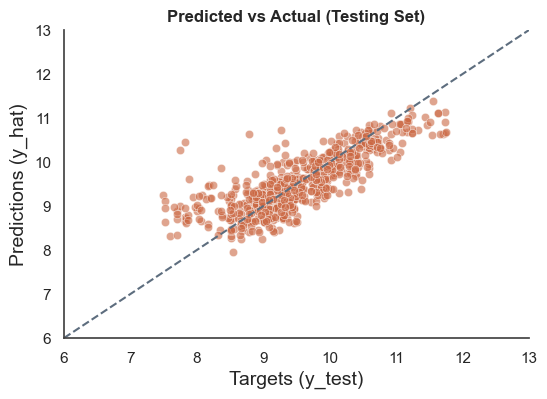

In [90]:
# Create a scatter plot with the test targets and the test predictions

plt.figure(figsize = (6, 4))
sns.scatterplot(x = y_test, y = y_hat_test, alpha = 0.6, color = warm_tones[4])
plt.plot([6, 13], [6, 13], color = cool_tones[3], linestyle = '--')  # 45° reference line

plt.xlabel('Targets (y_test)', size = 14)
plt.ylabel('Predictions (y_hat)', size = 14)
plt.title('Predicted vs Actual (Testing Set)', fontweight = 'bold')
plt.xlim(6, 13)
plt.ylim(6, 13)
plt.show()

**Observation:**

At first glance, the plot looks fairly promising. 
- We notice a **strong alignment** around the 45° line, especially for **higher-priced** vehicles, indicating **strong predictive performance** in that range.

- For **lower prices**, predictions are more scattered, showing **weaker accuracy**.

We also noticed mismatches due to old indices being preserved. Let’s reset the index to align predictions and targets properly:

In [93]:
# Reset the original indexing to match predicted and target values below
y_test = y_test.reset_index(drop=True)

### Converting Log Prices Back to Original Scale
Our model predicted log-prices. We’ll take the exponential to revert them back to actual price values:

In [95]:
# Convert log of Price back to the original values by taking its exponential
df_pf = pd.DataFrame(np.exp(y_hat_test), columns = ['Predictions'])
df_pf['Target'] = np.exp(y_test)

# Calculate the residual and the percent diff
df_pf['Residual'] = df_pf['Target'] - df_pf['Predictions']
df_pf['Diff %'] = abs(df_pf['Residual'] / df_pf['Target'] * 100)

### Performance Overview

Let’s explore the statistical summary of our predictions:

In [98]:
df_pf.describe()

,Predictions,Target,Residual,Diff %
count,692.000000,692.000000,692.000000,692.000000
mean,17011.741833,19131.800289,2120.058456,43.476414
std,12646.530579,19293.683298,11111.358986,85.216505
min,2848.063018,1800.000000,-34975.706043,0.055624
25%,8336.557891,8200.000000,-2939.857455,12.829551
50%,12364.086641,12189.500000,393.338753,25.463038
75%,21714.632927,22750.000000,3998.941371,43.510263
max,87332.428627,126000.000000,82569.398948,1285.628822


**Key Takeaways:**

- The **minimum percent error** is as low as **0.05%**, showing spot-on predictions in some cases.

- The **maximum percent error** is relatively large, indicating a few poor predictions.

- Overall, percentiles show that most predictions are reasonably close to actual values.

We can sort predictions by percentage error to manually inspect the model’s behavior to check for **outliers**:

In [100]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Sort by difference in % to manually check the model
df_pf.sort_values(by = ['Diff %'], ascending = False)

,Predictions,Target,Residual,Diff %
213,34640.72,2500.00,-32140.72,1285.63
643,29158.78,2300.00,-26858.78,1167.77
394,41170.76,6500.00,-34670.76,533.40
171,10489.13,1800.00,-8689.13,482.73
243,14850.78,2650.00,-12200.78,460.41
476,9079.57,1850.00,-7229.57,390.79
198,19264.24,4300.00,-14964.24,348.01
256,45575.71,10600.00,-34975.71,329.96
522,7700.69,1850.00,-5850.69,316.25
477,7892.26,2100.00,-5792.26,275.82


**Observation:**

- The largest errors occur for cars priced **extremely low** (`$3000`, `$4500`, `$2600`, etc.). In each of these outlier cases, the **predicted price is higher** than the actual (the residual is negative).

- We also notice that **extremely high-priced** cars are **underestimated** by the model.

- This may suggest **missing features**, such as damage status or vehicle condition, which could significantly impact price but weren't included in our dataset.

## Step 7: Final Insights

### Model Performance Overview

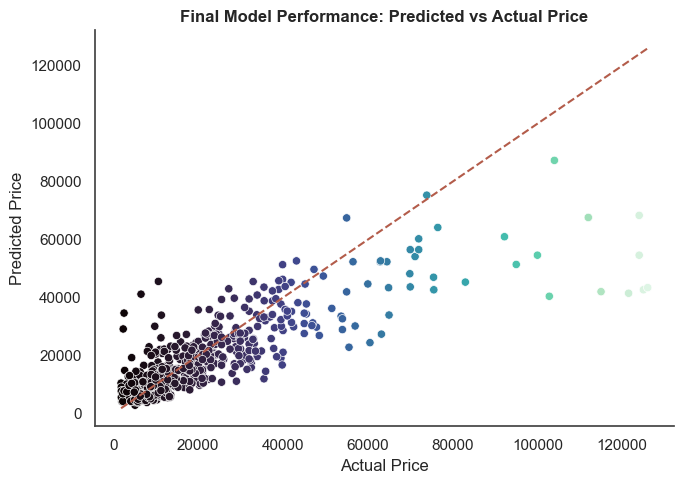

In [104]:
target_min = df_pf['Target'].min()
target_max = df_pf['Target'].max()

# Visualize the model performance in a scatter plot
plt.figure(figsize = (7, 5))
sns.scatterplot(data = df_pf, x = 'Target', y = 'Predictions', hue = 'Target', palette = 'mako', legend = False)
plt.plot([target_min, target_max], [target_min, target_max], color = warm_tones[0], linestyle = '--') # 45 deg line

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Final Model Performance: Predicted vs Actual Price', fontweight = 'bold')

plt.tight_layout()
plt.show()

After training and evaluating our linear regression model, we observed the following insights:

- **Strong overall performance:** The model performs reliably across most price ranges, particularly for **low to mid-priced** vehicles, showing consistent and accurate predictions.

- **Weaker performance for extremely low-priced cars:** Predictions for extremely low-priced vehicles (e.g., under $5,000) are more **scattered and less reliable**. This may be due to **unaccounted factors** or missing variables (e.g., mileage, damage condition, age) that influence pricing in that range.

- **Residual patterns reveal bias:** For outliers on the lower end of the price spectrum, residuals tend to be negative, meaning the model overestimates the actual price.

- **Underestimation of luxury cars:** The model tends to **underestimate extremely high-priced vehicles** (above $60,000). These appear to be outliers with limited representation in the dataset, which reduces the model’s ability to learn their pricing patterns effectively.

### Results & Insights

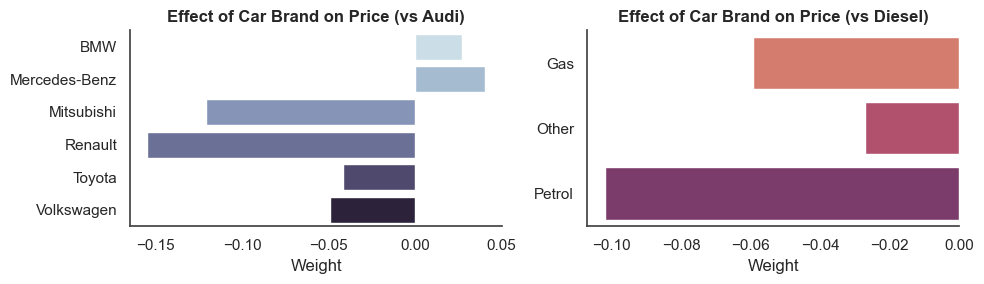

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Visualize 'Brand' weights in a bar plot
sns.barplot(data = brands_df, y = 'Features', x = 'Weights', hue = 'Features', palette = 'ch:s=.25,rot=-.25', ax = ax1)
ax1.set_title('Effect of Car Brand on Price (vs Audi)', fontdict = {'fontweight': 'bold'})
ax1.set_xlabel('Weight')
# ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylabel('')

# Visualize 'Engine Type' weights in a bar plot
sns.barplot(data = engine_df, y = 'Features', x = 'Weights', hue = 'Features', palette = 'flare', ax = ax2)
ax2.set_title('Effect of Car Brand on Price (vs Diesel)', fontdict = {'fontweight': 'bold'})
ax2.set_xlabel('Weight')
# ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

This project demonstrates that the linear regression model we built can provide valuable insights into car pricing. While it's not perfect — especially for extreme outliers — it performs well across most of the price range and helps us interpret the impact of different features like **mileage, engine volume, brand**, and **engine type**.

According to the model’s learned weights, **Renault** and **Mitsubishi** tend to drive prices lower, while **BMW** and **Mercedes-Benz** contribute to higher predicted prices, in comparision to **Audi**. In terms of engine type, **Petrol** vehicles are estimated to be significantly cheaper than **Diesel**, with **Gas** and **Other** engine types also pulling prices lower.

For further improvement:

- Include more features like car model, damage history, and year.  
- Handle outliers more effectively or transform features differently.  
- Consider using non-linear models or ensemble techniques.  

Overall, this was a strong first iteration, and the results show the power of interpretable, data-driven models in predicting real-world values.